NEW TRY

In [1]:
import torch
from torch_geometric.data import Data, Dataset
import networkx as nx
from networkx.algorithms.centrality import betweenness_centrality

from Datasets.synthetics import BA_2grid, BA_2grid_house, ProbingDataset, BA_2grid_to_test, BA_2grid_house_with_node_degree_as_features_and_expand_10_dimensions
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

import torch_geometric.utils as pyg_utils
import pickle as pkl
from torch_geometric.utils import from_networkx
import random
import torch.nn as nn

from models.models_BA_2grid import GIN_framework as framework
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch.optim as optim

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def set_seed(seed):
    if seed == -1:
        seed = random.randint(0, 1000)
    # Pandas also uses np random state by default
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
set_seed(43)

probe

In [5]:
MODEL = "GAT"
DATASET = "BA_2grid_house_with_node_degree_as_features_and_expand_10_dimensions"

# import the model
from models.models_BA_2grid_house import GAT_Framework_5 as framework
# import the dataset
from Datasets.synthetics import BA_2grid_house_with_node_degree_as_features_and_expand_10_dimensions

In [6]:
# inizialize the framework
dataset = BA_2grid_house_with_node_degree_as_features_and_expand_10_dimensions()
gnn = framework(dataset,device="cpu")

c:\Users\tomdu\OneDrive\Documents\ENSC_VU\4A-Vu\Thesis\Probing GNN\ProbingVenv\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
# the gnn object contains the train test split and the model.

print(gnn.model)
print(gnn.train_idx)
print(gnn.dataset[gnn.train_idx])

Net(
  (conv1): GATConv(10, 128, heads=8)
  (conv2): GATConv(1024, 128, heads=8)
  (conv3): GATConv(1024, 128, heads=8)
  (lin1): Linear(in_features=1024, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=2, bias=True)
)
tensor([ 701, 1225,   47,  ...,   40,  423,  494])
BA_2grid_house_with_node_degree_as_features_and_expand_10_dimensions(1600)


In [8]:
#now that the model is instaziated, we have to load the weights
gnn.load_model("models/"+DATASET+"_"+MODEL)
print("we loaded the weights")
# right now the model has trained weights.
#print(gnn.model.mlp1.weight[0])

INFO:root:Model loaded from: models/BA_2grid_house_with_node_degree_as_features_and_expand_10_dimensions_GAT


we loaded the weights


In [9]:
# train the model
gnn.evaluate()

INFO:root:Train Loss: 0.050, Train Acc: 0.988, Test Loss: 0.097, Test Acc: 0.968


In [10]:
import networkx as nx

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = nx.average_shortest_path_length(G) if nx.is_connected(G) else None
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        #small_world = nx.algorithms.smallworld.sigma(G)

        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component)) #, small_world))
    return properties

train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])


In [11]:
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

    

In [11]:
len(test_properties)

400

In [12]:
train_features, test_features = gnn.evaluate_with_features2()

In [13]:
len(train_features), len(test_features)

(1600, 400)

In [14]:
len(train_features[0])

6

### probing

In [15]:
# Evaluate to get features
train_features, test_features = gnn.evaluate_with_features2()

# Extract x_global and x_lin1 embeddings for training set
train_x_global = np.array([feat[0] for feat in train_features])
train_x_lin1 = np.array([feat[1] for feat in train_features])

#take only the first 10 elements
# train_x_global = train_x_global[:10]
# train_x_lin1 = train_x_lin1[:10]

# Extract x_global and x_lin1 embeddings for test set
test_x_global = np.array([feat[0] for feat in test_features])
test_x_lin1 = np.array([feat[1] for feat in test_features])

#take only the first 10 elements
# test_x_global = test_x_global[:10]
# test_x_lin1 = test_x_lin1[:10]


#### linear regression

In [17]:
import numpy as np

# Prepare training data
train_x = train_x_global  # or use train_x_lin1 if you prefer
train_y = np.array(train_properties)

# Prepare testing data
test_x = test_x_global  # or use test_x_lin1 if you prefer
test_y = np.array(test_properties)


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train a regression model for each graph property
models = []
for i in range(train_y.shape[1]):
    model = LinearRegression()
    model.fit(train_x, train_y[:, i])
    models.append(model)

# Evaluate the models
for i, model in enumerate(models):
    train_pred = model.predict(train_x)
    test_pred = model.predict(test_x)
    
    train_mse = mean_squared_error(train_y[:, i], train_pred)
    test_mse = mean_squared_error(test_y[:, i], test_pred)
    
    print(f'Property {i}: Train MSE: {train_mse:.3f}, Test MSE: {test_mse:.3f}')


Property 0: Train MSE: 14.205, Test MSE: 87.123
Property 1: Train MSE: 14.376, Test MSE: 98.167
Property 2: Train MSE: 0.000, Test MSE: 0.002
Property 3: Train MSE: 0.198, Test MSE: 1.326
Property 4: Train MSE: 21.141, Test MSE: 131.507


Linear model

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)


In [20]:
# Convert to PyTorch tensors
train_x = torch.tensor(train_x_global, dtype=torch.float32)
train_y = torch.tensor(train_properties, dtype=torch.float32)

test_x = torch.tensor(test_x_global, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)


In [21]:
len(train_x)

1600

In [22]:
train_y[:, 4]

tensor([28., 30., 30.,  ..., 26., 29., 22.])

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features()

# Extract x_global embeddings
train_x_global = np.array([feat[0] for feat in train_features])
test_x_global = np.array([feat[0] for feat in test_features])

# Extract 5th, 6th and 7th embeddings
train_x5 = np.array([feat[1] for feat in train_features])
test_x5 = np.array([feat[1] for feat in test_features])

train_x6 = np.array([feat[2] for feat in train_features])
test_x6 = np.array([feat[2] for feat in test_features])

train_x7 = np.array([feat[3] for feat in train_features])
test_x7 = np.array([feat[3] for feat in test_features])

# Compute graph properties
train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x_global, dtype=torch.float32)
train_y = torch.tensor(train_properties, dtype=torch.float32)

test_x = torch.tensor(test_x_global, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)



# Train and evaluate a model for each graph property and each embeddings
input_size = train_x.shape[1]
output_size = 1  # Predicting one property at a time

property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques']

# Train and evaluate a model for each graph property and each embeddings
input_size = train_x.shape[1]
output_size = 1  # Predicting one property at a time

property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques']

embeddings = [train_x, train_x5, train_x7]

for embedding in embeddings:
    # Train and evaluate a model for each graph property
    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 25000

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(embedding).squeeze().cpu().numpy()
            test_pred = model(test_x).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {embedding}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')


Epoch [1000/25000], Loss: 10.4596
Epoch [2000/25000], Loss: 9.6556
Epoch [3000/25000], Loss: 9.1268
Epoch [4000/25000], Loss: 8.7196
Epoch [5000/25000], Loss: 8.3821
Epoch [6000/25000], Loss: 8.0918
Epoch [7000/25000], Loss: 7.8621
Epoch [8000/25000], Loss: 7.7029
Epoch [9000/25000], Loss: 7.5928
Epoch [10000/25000], Loss: 7.5081
Epoch [11000/25000], Loss: 7.4388
Epoch [12000/25000], Loss: 7.3805
Epoch [13000/25000], Loss: 7.5046
Epoch [14000/25000], Loss: 7.2856
Epoch [15000/25000], Loss: 7.2456
Epoch [16000/25000], Loss: 7.2094
Epoch [17000/25000], Loss: 7.1765
Epoch [18000/25000], Loss: 7.1528
Epoch [19000/25000], Loss: 7.1177
Epoch [20000/25000], Loss: 7.0938
Epoch [21000/25000], Loss: 7.0666
Epoch [22000/25000], Loss: 7.0433
Epoch [23000/25000], Loss: 7.0215
Epoch [24000/25000], Loss: 7.0010
Epoch [25000/25000], Loss: 6.9815
Embedding: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 5.5616],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 5.9057],
        [0.0000, 0.

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1600x2 and 1024x1)

#### Probing pipeline

In [16]:
"""
The embeddings of GAT
return F.log_softmax(x_3, dim=-1), (x1, x2, x3, x_max_pool, x_2, x_3)
"""

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features()

# Extract x_global embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, global, 4, 5 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x_global = np.array([feat[3] for feat in train_features])
test_x_global = np.array([feat[3] for feat in test_features])

train_x4 = np.array([feat[4] for feat in train_features])
test_x4 = np.array([feat[4] for feat in test_features])

train_x5 = np.array([feat[5] for feat in train_features])
test_x5 = np.array([feat[5] for feat in test_features])

# Compute graph properties
train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_node_in_the_largest_fully_connected_component']  # Add more properties if needed
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x_global, test_x_global), (train_x4, test_x4), (train_x5, test_x5)]
embeddings_names = ['x', 'x2', 'x3', 'x_global', 'x4', 'x5']
#create a dictionary where we will sotre the results for each embeddings, each property
results = {}
ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 10000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')
            
            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

Epoch [1000/10000], Property: num_nodes, Loss: 34.2270
Epoch [2000/10000], Property: num_nodes, Loss: 26.1288
Epoch [3000/10000], Property: num_nodes, Loss: 21.4168
Epoch [4000/10000], Property: num_nodes, Loss: 18.5236
Epoch [5000/10000], Property: num_nodes, Loss: 15.7902
Epoch [6000/10000], Property: num_nodes, Loss: 13.1605
Epoch [7000/10000], Property: num_nodes, Loss: 10.9278
Epoch [8000/10000], Property: num_nodes, Loss: 9.3786
Epoch [9000/10000], Property: num_nodes, Loss: 8.5873
Epoch [10000/10000], Property: num_nodes, Loss: 8.3259
Embedding: torch.Size([1600, 1024])
Property: num_nodes
  Train MSE: 8.3258, Test MSE: 8.0997
  Train R²: -0.0081, Test R²: -0.0065
Epoch [1000/10000], Property: num_edges, Loss: 46.1437
Epoch [2000/10000], Property: num_edges, Loss: 36.1065
Epoch [3000/10000], Property: num_edges, Loss: 29.4128
Epoch [4000/10000], Property: num_edges, Loss: 25.5087
Epoch [5000/10000], Property: num_edges, Loss: 22.0941
Epoch [6000/10000], Property: num_edges, Loss

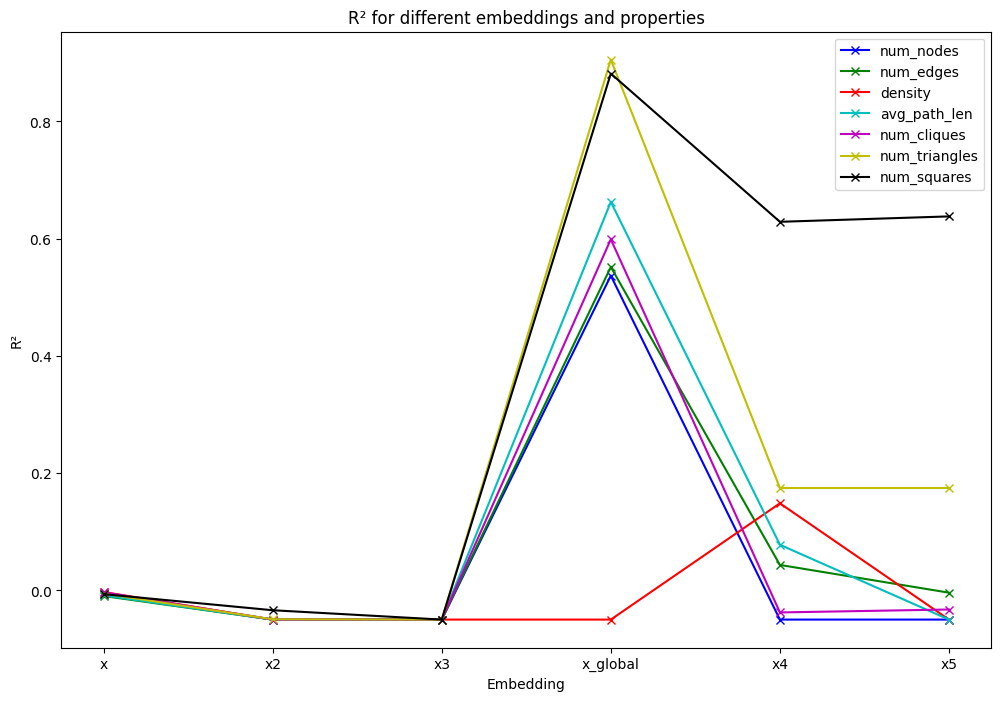

In [19]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x_global, test_x_global), (train_x4, test_x4), (train_x5, test_x5)]
embeddings_names = ['x', 'x2', 'x3', 'x_global', 'x4', 'x5']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('R² for different embeddings and properties')
plt.show()
